In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from utils import AverageMeter, ProgressMeter

In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.fc1 = nn.Linear(6272, 512)
        self.fc2 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        batch_size, C, H, W = x.shape
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
summary(model, input_size=(3, 150, 150))
# x = torch.rand(1, 3, 150, 150)
# model(x)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
            Conv2d-2           [-1, 64, 72, 72]          18,496
            Conv2d-3          [-1, 128, 34, 34]          73,856
            Conv2d-4          [-1, 128, 15, 15]         147,584
            Linear-5                  [-1, 512]       3,211,776
            Linear-6                    [-1, 1]             513
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 9.23
Params size (MB): 13.17
Estimated Total Size (MB): 22.66
----------------------------------------------------------------


In [4]:
train_transforms = transforms.Compose([transforms.Resize((150, 150)),                                
                                       transforms.ToTensor(),
                                       ])
train_dir = r"/data/bitt/wzq/wzq/python-deep-learning/data/cats_and_dogs_small/train"
train_data = data.ImageFolder(train_dir, train_transforms)
print(train_data)
train_loader = DataLoader(train_data, batch_size=20, shuffle=True)
print(train_data.classes)
validation_dir = r"/data/bitt/wzq/wzq/python-deep-learning/data/cats_and_dogs_small/validation"
val_transforms = transforms.Compose([transforms.Resize((150, 150)),                                
                                       transforms.ToTensor(),
                                       ])
validation_data = data.ImageFolder(validation_dir, val_transforms)
print(validation_data)
val_loader = DataLoader(validation_data, batch_size=20)

Dataset ImageFolder
    Number of datapoints: 2000
    Root Location: /data/bitt/wzq/wzq/python-deep-learning/data/cats_and_dogs_small/train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None
['cats', 'dogs']
Dataset ImageFolder
    Number of datapoints: 1000
    Root Location: /data/bitt/wzq/wzq/python-deep-learning/data/cats_and_dogs_small/validation
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None


In [5]:
for i, (data_batch, labels_batch) in enumerate(train_loader):
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: torch.Size([20, 3, 150, 150])
labels batch shape: torch.Size([20])


In [6]:
def evaluate(model, device, criteria, test_loader):
    losses = AverageMeter("Loss", ":.4e")
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = target.to(device).float().view(-1, 1)
            pred = model(data)
            loss = criteria(pred, target)
            output = pred > 0.5
            predict = torch.zeros_like(output).float()
            predict[output] = 1.0
            correct += predict.eq(target.view_as(predict)).sum().item()
            losses.update(loss.item(), target.size(0))
    print('Test set: Accuracy: {}/{} ({:.0f}%)'.format(
    correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    return losses, correct / len(test_loader.dataset)

In [7]:
def train(model, device, train_loader, criteria, optimizer):
    losses = AverageMeter("Loss", ":.4e")
    acc = AverageMeter("Acc", ":6.2f")
    progress = ProgressMeter(len(train_loader), losses, acc)
    model.train()
    for i, (data_batch, labels_batch) in enumerate(train_loader):
        data_batch = data_batch.to(device)
        labels_batch = labels_batch.to(device).float().view(-1, 1)
        pred = model(data_batch)
        output = pred > 0.5
        predict = torch.zeros_like(output).float()
        predict[output] = 1.0
        top1 = predict.eq(labels_batch.view_as(predict)).sum().item() / labels_batch.size(0)
        acc.update(top1, labels_batch.size(0))
        loss = criteria(pred, labels_batch)
        losses.update(loss.item(), data_batch.size(0))       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            progress.pr2int(i)
    return losses, acc

In [8]:
criteria = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4, alpha=0.9)
loss = []
acc = []
val_loss = []
val_acc = []
for epoch in range(30):
    print("Epoch: ", epoch)
    loss1, acc1 = train(model, device, train_loader, criteria, optimizer)
    val_loss1, val_acc1 = evaluate(model, device, criteria, val_loader)
    loss.append(loss1.avg) 
    acc.append(acc1.avg)
    val_loss.append(val_loss1.avg)
    val_acc.append(val_acc1)

Epoch:  0
[  0/100]	Loss 6.9313e-01 (6.9313e-01)	Acc   0.50 (  0.50)
[ 10/100]	Loss 6.9381e-01 (6.9516e-01)	Acc   0.45 (  0.47)
[ 20/100]	Loss 6.9289e-01 (6.9465e-01)	Acc   0.50 (  0.47)
[ 30/100]	Loss 6.9597e-01 (6.9416e-01)	Acc   0.40 (  0.49)
[ 40/100]	Loss 6.9335e-01 (6.9389e-01)	Acc   0.45 (  0.49)
[ 50/100]	Loss 6.9964e-01 (6.9370e-01)	Acc   0.40 (  0.49)
[ 60/100]	Loss 6.8155e-01 (6.9324e-01)	Acc   0.60 (  0.51)
[ 70/100]	Loss 6.8722e-01 (6.9354e-01)	Acc   0.60 (  0.51)
[ 80/100]	Loss 6.9121e-01 (6.9345e-01)	Acc   0.60 (  0.51)
[ 90/100]	Loss 6.8935e-01 (6.9334e-01)	Acc   0.50 (  0.51)
Test set: Accuracy: 587/1000 (59%)
Epoch:  1
[  0/100]	Loss 6.8670e-01 (6.8670e-01)	Acc   0.60 (  0.60)
[ 10/100]	Loss 6.8020e-01 (6.8613e-01)	Acc   0.60 (  0.59)
[ 20/100]	Loss 6.7431e-01 (6.8838e-01)	Acc   0.70 (  0.56)
[ 30/100]	Loss 6.8224e-01 (6.8845e-01)	Acc   0.55 (  0.57)
[ 40/100]	Loss 6.7731e-01 (6.8901e-01)	Acc   0.45 (  0.56)
[ 50/100]	Loss 6.8579e-01 (6.8771e-01)	Acc   0.55 (  0.56)
[

Test set: Accuracy: 661/1000 (66%)
Epoch:  13
[  0/100]	Loss 4.2994e-01 (4.2994e-01)	Acc   0.80 (  0.80)
[ 10/100]	Loss 6.3284e-01 (4.6813e-01)	Acc   0.75 (  0.77)
[ 20/100]	Loss 5.3686e-01 (4.6986e-01)	Acc   0.80 (  0.78)
[ 30/100]	Loss 5.3859e-01 (4.5850e-01)	Acc   0.75 (  0.80)
[ 40/100]	Loss 4.4267e-01 (4.6038e-01)	Acc   0.75 (  0.79)
[ 50/100]	Loss 4.0332e-01 (4.5872e-01)	Acc   0.85 (  0.79)
[ 60/100]	Loss 4.0434e-01 (4.5795e-01)	Acc   0.80 (  0.78)
[ 70/100]	Loss 4.9500e-01 (4.5289e-01)	Acc   0.80 (  0.79)
[ 80/100]	Loss 3.1495e-01 (4.6132e-01)	Acc   0.95 (  0.78)
[ 90/100]	Loss 5.1332e-01 (4.6480e-01)	Acc   0.70 (  0.78)
Test set: Accuracy: 709/1000 (71%)
Epoch:  14
[  0/100]	Loss 3.6649e-01 (3.6649e-01)	Acc   0.85 (  0.85)
[ 10/100]	Loss 3.9473e-01 (4.7025e-01)	Acc   0.80 (  0.79)
[ 20/100]	Loss 3.7978e-01 (4.5835e-01)	Acc   0.90 (  0.80)
[ 30/100]	Loss 2.8700e-01 (4.4928e-01)	Acc   0.90 (  0.81)
[ 40/100]	Loss 5.4026e-01 (4.5476e-01)	Acc   0.65 (  0.80)
[ 50/100]	Loss 4.6860e-

[ 90/100]	Loss 1.9831e-01 (2.9282e-01)	Acc   0.95 (  0.88)
Test set: Accuracy: 734/1000 (73%)
Epoch:  26
[  0/100]	Loss 3.1975e-01 (3.1975e-01)	Acc   0.90 (  0.90)
[ 10/100]	Loss 2.9241e-01 (2.7392e-01)	Acc   0.80 (  0.86)
[ 20/100]	Loss 2.5034e-01 (2.7137e-01)	Acc   0.90 (  0.89)
[ 30/100]	Loss 2.4626e-01 (2.6504e-01)	Acc   0.90 (  0.89)
[ 40/100]	Loss 3.4932e-01 (2.6670e-01)	Acc   0.85 (  0.89)
[ 50/100]	Loss 2.9793e-01 (2.5222e-01)	Acc   0.90 (  0.90)
[ 60/100]	Loss 4.6266e-01 (2.7480e-01)	Acc   0.80 (  0.89)
[ 70/100]	Loss 4.8054e-01 (2.7215e-01)	Acc   0.80 (  0.89)
[ 80/100]	Loss 1.9922e-01 (2.8056e-01)	Acc   0.95 (  0.88)
[ 90/100]	Loss 1.7558e-01 (2.8202e-01)	Acc   1.00 (  0.88)
Test set: Accuracy: 742/1000 (74%)
Epoch:  27
[  0/100]	Loss 1.8431e-01 (1.8431e-01)	Acc   0.95 (  0.95)
[ 10/100]	Loss 2.9522e-01 (2.5661e-01)	Acc   0.90 (  0.92)
[ 20/100]	Loss 4.1687e-01 (2.5316e-01)	Acc   0.90 (  0.91)
[ 30/100]	Loss 3.5753e-01 (2.5260e-01)	Acc   0.85 (  0.91)
[ 40/100]	Loss 5.9268e-

In [9]:
torch.save(model, 'dogs_and_cats_small.pt')

/data/bitt/wzq/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [10]:
import matplotlib.pyplot as plt

In [11]:
epoches = range(1, len(acc)+1)

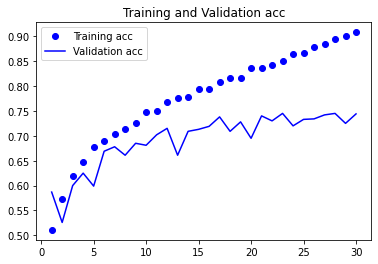

In [12]:
plt.plot(epoches, acc, 'bo', label="Training acc")
plt.plot(epoches, val_acc, 'b', label='Validation acc')
plt.title("Training and Validation acc")
plt.legend()
plt.show()

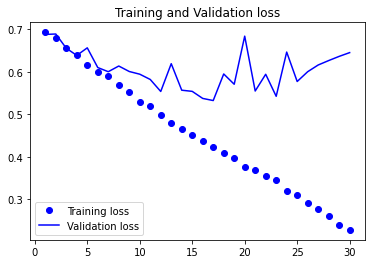

In [13]:
plt.plot(epoches, loss, 'bo', label='Training loss')
plt.plot(epoches, val_loss, 'b', label='Validation loss')
plt.legend()
plt.title("Training and Validation loss")
plt.show()

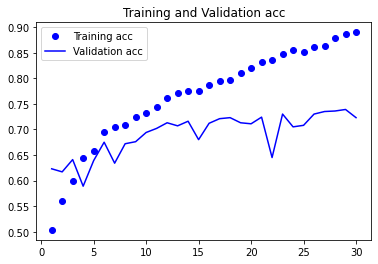

In [12]:
plt.plot(epoches, acc, 'bo', label="Training acc")
plt.plot(epoches, val_acc, 'b', label='Validation acc')
plt.title("Training and Validation acc")
plt.legend()
plt.show()

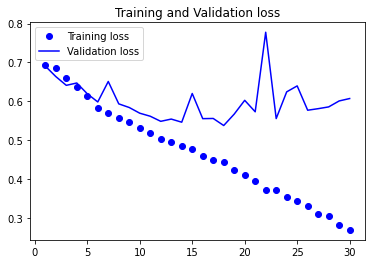

In [13]:
plt.plot(epoches, loss, 'bo', label='Training loss')
plt.plot(epoches, val_loss, 'b', label='Validation loss')
plt.legend()
plt.title("Training and Validation loss")
plt.show()